In [1]:
pip install torch==2.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 129.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 26.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 17.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 39.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 14.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

# Preperation

In [2]:
import gc
import math
import time

import torch
import numpy as np
import pandas as pd
import torch._dynamo
import torch.nn as nn
import scipy.stats as stats
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")
torch._functorch.config.donated_buffer=False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 14,
    'figure.dpi': 100,
    'legend.loc': 'upper left',
})

In [3]:
EPOCHS = 50_000
LEARNING_RATE = 4e-4
DATA_BATCH_SIZE = int(4_096*1.5)
COLLOC_BATCH_SIZE = int(DATA_BATCH_SIZE*3)
WARMUP_EPOCHS = 1_500
RAMPUP_EPOCHS = 5_000
PDE_WEIGHT_TARGET = 0.51
LEARNING_RATE_FACTOR = 0.5
LEARNING_RATE_PATIENCE = 750
R_M = 0.60
R_T = 0.35
ATM_TC_SAMPLING = 0.20
ATM_COLLOC_SAMPLING = 0.25
T_SKEW=1.40
M_SKEW=1.70

In [5]:
df = pd.read_csv(r'filtered_data.csv')
call_df = df[df['Option_Type'] == 'put'].copy()
call_df.drop(columns=['Unnamed: 0'], inplace=True)

call_df.loc[:, 'Dividend_Yield'] = call_df['Dividend_Yield'] / 100
call_df.loc[:, 'RF'] = call_df['RF'] / 100
call_df.loc[:, 'Implied_Volatility'] = call_df['Implied_Volatility'] / 100

max_tau = 90/365.25
call_df.loc[:, 't'] = max_tau - call_df['Time_to_Exp']
call_df = call_df[call_df['Time_to_Exp'] <= max_tau]

moneyness_labels = ['OTM', 'ATM', 'ITM']
moneyness_conditions = [
    call_df['Moneyness'] > 1.03,
    (call_df['Moneyness'] >= 0.97) & (call_df['Moneyness'] <= 1.03),
    call_df['Moneyness'] < 0.97
]
call_df['moneyness_labels'] = np.select(moneyness_conditions, moneyness_labels, default='Other')

X_market = call_df[['Underlying_Price', 'Strike', 't', 'RF', 'Dividend_Yield']].to_numpy()
Y_market = call_df[['Option_Price']].to_numpy()
market_moneyness_labels = call_df['moneyness_labels'].to_numpy()

spot_bounds = (call_df['Underlying_Price'].min(), call_df['Underlying_Price'].max())
strike_bounds = (call_df['Strike'].min(), call_df['Strike'].max())
time_bounds = (call_df['t'].min(), call_df['t'].max())
rate_bounds = (call_df['RF'].min(), call_df['RF'].max())
dividend_bounds = (call_df['Dividend_Yield'].min(), call_df['Dividend_Yield'].max())
moneyness_bounds = (call_df['Moneyness'].min(), call_df['Moneyness'].max())
moneyness_mean = call_df['Moneyness'].mean()

print(f"{call_df['moneyness_labels'].value_counts(normalize=True)}\n")

print(f"95% Implied Volatility: {call_df['Implied_Volatility'].quantile(0.95)}")
print(f"99% Implied Volatility: {call_df['Implied_Volatility'].quantile(0.99)}")
print(f"99.5% Implied Volatility: {call_df['Implied_Volatility'].quantile(0.995)}")
print(f"99.9% Implied Volatility: {call_df['Implied_Volatility'].quantile(0.999)}\n")

call_df.describe()

moneyness_labels
OTM    0.750744
ATM    0.192813
ITM    0.056443
Name: proportion, dtype: float64

95% Implied Volatility: 0.6507999999999999
99% Implied Volatility: 0.9167000000000001
99.5% Implied Volatility: 1.0449040000000038
99.9% Implied Volatility: 1.3736395010000486



,Option_Price,Option_Volume,Strike,Time_to_Exp,Implied_Volatility,RF,Underlying_Price,Dividend_Yield,Moneyness,t
count,124338.000000,124338.000000,124338.000000,124338.000000,124338.000000,124338.000000,124338.000000,124338.000000,124338.000000,124338.000000
mean,38.261007,713.159276,3510.663192,0.071190,0.323528,0.024991,3926.596936,0.021095,1.135087,0.175217
std,98.738724,1951.421053,948.387089,0.047432,0.173621,0.021016,934.668319,0.003424,0.136824,0.047432
min,0.010000,10.000000,1800.000000,0.005476,0.029227,-0.000460,2237.400000,0.014950,0.581983,0.000000
25%,1.500000,30.000000,2750.000000,0.038330,0.201300,0.001570,3090.230000,0.018310,1.030224,0.150582
50%,6.760000,102.000000,3370.000000,0.065708,0.286144,0.021050,3900.110000,0.021124,1.107882,0.180698
75%,29.100000,448.000000,4130.000000,0.095825,0.402900,0.047730,4483.870000,0.023614,1.222649,0.208077
max,2284.870000,68793.000000,6000.000000,0.246407,1.775600,0.055170,6090.270000,0.034420,1.499988,0.240931


In [15]:
print(call_df['moneyness_labels'].value_counts(normalize=True))

moneyness_labels
OTM    0.750744
ATM    0.192813
ITM    0.056443
Name: proportion, dtype: float64


# Sampling

In [6]:
def generate_collocation_points(n_samples, spot_bounds, strike_bounds,
                                tau_bounds, rate_bounds, dividend_bounds,
                                moneyness_bounds, moneyness_mean, seed=SEED):

    rng = np.random.RandomState(seed)

    n_atm = int(n_samples * ATM_COLLOC_SAMPLING)
    atm_moneyness_bounds = (0.97, 1.03)

    if n_atm > 0:
        s_atm = rng.uniform(*spot_bounds, size=n_atm)
        m_atm = rng.uniform(*atm_moneyness_bounds, size=n_atm)
        k_atm = s_atm / m_atm

        valid_mask = (k_atm >= strike_bounds[0]) * (k_atm <= strike_bounds[1])
        s_atm, k_atm = s_atm[valid_mask], k_atm[valid_mask]

        n_atm = len(s_atm)

        tau_atm = rng.uniform(*tau_bounds, size=n_atm)
        t_atm = ((90/365.25) - tau_atm)
        r_atm = rng.uniform(*rate_bounds, size=n_atm)
        d_atm = rng.uniform(*dividend_bounds, size=n_atm)

        X_atm = np.stack([s_atm, k_atm, t_atm, r_atm, d_atm], axis=1)
    else:
        X_atm = np.array([]).reshape(0, 5)

    n_regular = n_samples - n_atm
    X_regular = np.empty((n_regular, 5))
    filled = 0

    batch_size = min(50_000, max(1_000, 2 * n_regular))

    while filled < n_regular:

        s_points = rng.uniform(*spot_bounds, size=(batch_size))

        u_m = rng.uniform(0, 1, size=(batch_size))
        m_points = moneyness_bounds[0] + (moneyness_bounds[1] - moneyness_bounds[0]) * (1 - (1 - u_m)**M_SKEW)

        k_points = s_points/m_points

        valid_mask = (
            (m_points >= moneyness_bounds[0]) &
            (m_points <= moneyness_bounds[1]) &
            (k_points >= strike_bounds[0]) &
            (k_points <= strike_bounds[1])
        )

        s = s_points[valid_mask]
        k = k_points[valid_mask]

        num_valid = len(s)
        if num_valid == 0:
            continue

        u = rng.uniform(0, 1, size=(batch_size))
        tau = tau_bounds[0] + (tau_bounds[1] - tau_bounds[0]) * (u**T_SKEW)
        t = ((90/365.25) - tau)
        r = rng.uniform(*rate_bounds, size=(batch_size))
        d = rng.uniform(*dividend_bounds, size=(batch_size))

        take = min(num_valid, n_regular - filled)

        X_regular[filled:filled+take, 0] = s[:take]
        X_regular[filled:filled+take, 1] = k[:take]
        X_regular[filled:filled+take, 2] = t[:take]
        X_regular[filled:filled+take, 3] = r[:take]
        X_regular[filled:filled+take, 4] = d[:take]

        filled += take

    X = np.vstack([X_regular, X_atm])
    rng.shuffle(X)

    return X


def generate_tc_points(n_samples, atm_sampling, spot_bounds, strike_bounds, tau_bounds, rate_bounds, dividend_bounds, seed=SEED):
    rng = np.random.RandomState(seed)

    if atm_sampling > 0:
        n_atm = n_samples
        atm_moneyness_bounds = (0.97, 1.03)

        s_atm = rng.uniform(*spot_bounds, size=n_atm)
        m_atm = rng.uniform(*atm_moneyness_bounds, size=n_atm)
        k_atm = s_atm / m_atm

        valid_mask = (k_atm >= strike_bounds[0]) * (k_atm <= strike_bounds[1])
        s_atm, k_atm = s_atm[valid_mask], k_atm[valid_mask]

        s = np.vstack([s_atm.reshape(-1, 1)])
        k = np.vstack([k_atm.reshape(-1, 1)])

        l = np.full(len(s), "terminal_atm", dtype="<U7")

    else:
        n_regular = n_samples
        s_regular = rng.uniform(*spot_bounds, size=(n_regular, 1))
        k_regular = rng.uniform(*strike_bounds, size=(n_regular, 1))

        s = np.vstack([s_regular.reshape(-1, 1)])
        k = np.vstack([k_regular.reshape(-1, 1)])

        l = np.full(len(s), "terminal_regular", dtype="<U7")

    current_n_samples = len(s)
    t = np.full((current_n_samples, 1), (90/365.25))
    r = rng.uniform(*rate_bounds, size=(current_n_samples, 1))
    q = rng.uniform(*dividend_bounds, size=(current_n_samples, 1))

    X_tc = np.hstack([s, k, t, r, q])
    Y_tc = np.maximum(k - s, 0.0)
    terminal_labels = l

    return X_tc, Y_tc, terminal_labels


def generate_bc_points(n_samples, spot_bounds, strike_bounds, tau_bounds, rate_bounds, dividend_bounds, seed=SEED):
    rng = np.random.RandomState(seed)

    n_s0 = n_samples // 2

    S = np.zeros((n_s0, 1))
    K = rng.uniform(*strike_bounds, size=(n_s0, 1))
    tau = rng.uniform(*tau_bounds, size=(n_s0, 1))
    t = ((90/365.25) - tau)
    r = rng.uniform(*rate_bounds, size=(n_s0, 1))
    q = rng.uniform(*dividend_bounds, size=(n_s0, 1))
    X_s0 = np.hstack([S, K, t, r, q])
    Y_s0 = K * np.exp(-r * tau)

    n_sinf = n_samples - n_s0
    large_spot_val = strike_bounds[1] * 4

    S = np.full((n_sinf, 1), large_spot_val)
    K = rng.uniform(*strike_bounds, size=(n_sinf, 1))
    tau = rng.uniform(*tau_bounds, size=(n_sinf, 1))
    t = ((90/365.25) - tau)
    r = rng.uniform(*rate_bounds, size=(n_sinf, 1))
    q = rng.uniform(*dividend_bounds, size=(n_sinf, 1))
    X_smax = np.hstack([S, K, t, r, q])
    Y_smax = np.zeros((n_sinf, 1))

    b_s0_labels = np.full(len(X_s0), "null", dtype="<U7")
    b_max_labels = np.full(len(X_smax), "max", dtype="<U7")

    return X_s0, X_smax, Y_s0, Y_smax, b_s0_labels, b_max_labels


def create_train_test_split(market_data, terminal_boundary_data, train_ratio=0.8, val_ratio=0.1, seed=SEED):

    test_ratio = 1.0 - train_ratio - val_ratio
    train_sets, val_sets, test_sets = {}, {}, {}


    X_market, Y_market, market_labels = market_data
    X_m_train, X_m_rem, Y_m_train, Y_m_rem, labels_m_train, labels_m_rem = train_test_split(
        X_market, Y_market, market_labels,
        train_size=train_ratio, stratify=market_labels, random_state=seed
    )

    relative_test_size = test_ratio / (val_ratio + test_ratio)
    X_m_val, X_m_test, Y_m_val, Y_m_test = train_test_split(
        X_m_rem, Y_m_rem,
        test_size=relative_test_size, stratify=labels_m_rem, random_state=seed
    )

    train_sets['market'] = (X_m_train, Y_m_train)
    val_sets['market'] = (X_m_val, Y_m_val)
    test_sets['market'] = (X_m_test, Y_m_test)

    for name, (X, Y, L) in terminal_boundary_data.items():
        X_train, X_rem, Y_train, Y_rem, labels_t_b_train, labels_t_b_rem = train_test_split(
            X, Y, L, train_size=train_ratio, stratify=L, random_state=seed
        )

        X_val, X_test, Y_val, Y_test = train_test_split(
            X_rem, Y_rem,
            test_size=relative_test_size, stratify=labels_t_b_rem, random_state=seed
        )

        train_sets[name] = (X_train, Y_train)
        val_sets[name] = (X_val, Y_val)
        test_sets[name] = (X_test, Y_test)

    all_X_val = np.vstack([arr[0] for arr in val_sets.values()])
    all_Y_val = np.vstack([arr[1] for arr in val_sets.values()])

    all_X_test = np.vstack([arr[0] for arr in test_sets.values()])
    all_Y_test = np.vstack([arr[1] for arr in test_sets.values()])

    all_X_train = np.vstack([arr[0] for arr in train_sets.values()])
    all_Y_train = np.vstack([arr[1] for arr in train_sets.values()])

    x_min = all_X_train.min(axis=0)
    x_max = all_X_train.max(axis=0)
    x_range = x_max - x_min

    y_min = all_Y_train.min(axis=0)
    y_max = all_Y_train.max(axis=0)
    y_range = y_max - y_min

    return train_sets, (all_X_val, all_Y_val), (all_X_test, all_Y_test), x_min, x_range, y_min, y_range

# Classes

In [7]:
class MetricsLogger:
    def __init__(self):
        self.history = []
        self._batch_metrics = {}

    def log_batch(self, metrics):
        for key, value in metrics.items():
            if key not in self._batch_metrics:
                self._batch_metrics[key] = []
            self._batch_metrics[key].append(value)

    def log_epoch(self, epoch_metrics):
        epoch_summary = epoch_metrics.copy()
        for key, values in self._batch_metrics.items():
            epoch_summary[f'avg_{key}'] = sum(values) / len(values)

        self.history.append(epoch_summary)
        self._batch_metrics = {}

    def to_dataframe(self):
        return pd.DataFrame(self.history)

    def save_to_csv(self, filename="training_metrics.csv"):
        df = self.to_dataframe()
        df.to_csv(filename, index=False)
        print(f"Metrics saved to {filename}")

In [8]:
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        mods = []
        for i in range(len(layers) - 2):
            mods.append(nn.Linear(layers[i], layers[i + 1]))
            mods.append(nn.Tanh())
        mods.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*mods).to(DEVICE)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

class PINN(nn.Module):
    def __init__(self, layers, y_min, y_range, x_min, x_range):
        super().__init__()
        
        self.net = MLP(layers)
        self.softplus = nn.Softplus()

        self.register_buffer("y_min",   torch.tensor(y_min,   dtype=torch.float32))
        self.register_buffer("y_range", torch.tensor(y_range, dtype=torch.float32))
        self.register_buffer("x_min",   torch.tensor(x_min,   dtype=torch.float32))
        self.register_buffer("x_range", torch.tensor(x_range, dtype=torch.float32))

        self.register_buffer("sigma_min", torch.tensor(0.0292, dtype=torch.float32))
        self.register_buffer("sigma_max", torch.tensor(1.7756, dtype=torch.float32))

    def forward(self, x_norm):

        output = self.net(x_norm)
        pred_norm_V, sigma = output.split(1, dim=1)

        V = self.softplus(pred_norm_V) * self.y_range + self.y_min
        sigma = self.sigma_min + (self.sigma_max - self.sigma_min) * self.softplus(sigma)

        return pred_norm_V, V, sigma

    def pde_res(self, Xc, Xc_norm):

        _, V, sigma = self.forward(Xc_norm)

        grads = torch.autograd.grad(V, Xc, torch.ones_like(V), create_graph=True, retain_graph=True)
        dV_dS = grads[0][:, 0:1]
        dV_dt = grads[0][:, 2:3]

        hess = torch.autograd.grad(dV_dS, Xc, torch.ones_like(dV_dS), create_graph=True, retain_graph=True)
        d2V_dS2 = hess[0][:, 0:1]

        S = Xc[:, 0:1]
        r = Xc[:, 3:4]
        q = Xc[:, 4:5]

        res = (dV_dt + 0.5 * sigma**2 * S**2 * d2V_dS2 + (r - q) * S * dV_dS - r * V)
        return res

# Training Loop

In [12]:
def get_grad_norm_ratio(model, X_b, Y_b, Xc, pde_w):

    model.zero_grad()

    X_b_norm = 2 * (X_b - model.x_min) / model.x_range - 1
    _, V, _ = model(X_b_norm)

    loss_data = torch.mean((V - Y_b)**2)

    grads_data = torch.autograd.grad(loss_data, model.parameters(), retain_graph=True)
    grad_norm_data = torch.sqrt(sum(torch.sum(g**2) for g in grads_data))

    Xc_norm = 2 * (Xc - model.x_min) / model.x_range - 1
    pde_res = model.pde_res(Xc, Xc_norm)

    loss_pde = torch.mean(pde_res**2)
    w_loss_pde = loss_pde * pde_w

    grads_pde = torch.autograd.grad(w_loss_pde, model.parameters(), retain_graph=False)
    grad_norm_pde = torch.sqrt(sum(torch.sum(g**2) for g in grads_pde))

    ratio = (grad_norm_pde / grad_norm_data).item()

    return ratio, grad_norm_data.detach().item(), grad_norm_pde.detach().item()

def make_train_step(model, optimizer):
    def train_step(Xm_b, Ym_b, Xt_b, Yt_b, Xb_b, Yb_b, Xc, pde_w):
        optimizer.zero_grad(set_to_none=True)

        X_b = torch.cat([Xm_b, Xt_b, Xb_b], dim=0)
        Y_b = torch.cat([Ym_b, Yt_b, Yb_b], dim=0)

        X_b_norm = 2 * (X_b - model.x_min) / model.x_range - 1
        _, V, _ = model(X_b_norm)

        n_m = Xm_b.shape[0]
        n_t = Xt_b.shape[0]
        n_b = Xb_b.shape[0]

        V_mkt, V_tc, V_bc = torch.split(V, [n_m, n_t, n_b])
        Y_mkt, Y_tc, Y_bc = torch.split(Y_b, [n_m, n_t, n_b])

        loss_mkt = torch.mean((V_mkt - Y_mkt)**2)
        loss_tc = torch.mean((V_tc - Y_tc)**2)
        loss_bc = torch.mean((V_bc - Y_bc)**2)

        loss_data = loss_mkt + loss_tc + loss_bc

        if pde_w > 0 and Xc.shape[0] > 0:
            Xc_norm = 2 * (Xc - model.x_min) / model.x_range - 1
            pde_res = model.pde_res(Xc, Xc_norm)
            loss_pde = torch.mean(pde_res**2)
        else:
            loss_pde = torch.tensor(0.0, device=DEVICE)

        w_loss_pde = loss_pde * pde_w
        total_loss = loss_data + w_loss_pde
        
        total_loss.backward()
        optimizer.step()

        return loss_mkt, loss_tc, loss_bc, loss_data, loss_pde
    return train_step

def train_model(model, train_sets, Xva, Yva, Xc_pool, logger):

    model.train()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_step = make_train_step(model, optimizer)

    Xm_np, Ym_np = train_sets["market"]
    Xt_np, Yt_np = train_sets["terminal"]
    Xb_np = np.vstack([train_sets["boundary_s0"][0], train_sets["boundary_smax"][0]]) 
    Yb_np = np.vstack([train_sets["boundary_s0"][1], train_sets["boundary_smax"][1]])

    Xm, Ym = torch.from_numpy(Xm_np).float().to(DEVICE), torch.from_numpy(Ym_np).float().to(DEVICE)
    Xt, Yt = torch.from_numpy(Xt_np).float().to(DEVICE), torch.from_numpy(Yt_np).float().to(DEVICE)
    Xb, Yb = torch.from_numpy(Xb_np).float().to(DEVICE), torch.from_numpy(Yb_np).float().to(DEVICE)

    X_val = torch.from_numpy(Xva).float().to(DEVICE)
    Y_val = torch.from_numpy(Yva).float().to(DEVICE)
    Xc_pool = torch.from_numpy(Xc_pool).float().to(DEVICE)

    del train_sets, Xm_np, Ym_np, Xt_np, Yt_np, Xb_np, Yb_np

    r_m, r_t = R_M, R_T
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=LEARNING_RATE_FACTOR, patience=LEARNING_RATE_PATIENCE, min_lr=1e-7)

    n_m = int(DATA_BATCH_SIZE * r_m)
    n_t = int(DATA_BATCH_SIZE * r_t)
    n_b = DATA_BATCH_SIZE - n_m - n_t

    grad_ratio = 0.0
    grad_norm_data = 0.0
    grad_norm_pde = 0.0
    
    t_start = time.time()
    for epoch in range(EPOCHS):
        e_start = time.time()

        if epoch < WARMUP_EPOCHS:
            pde_w = 0.0
            num_batches = math.ceil(Xm.shape[0] / (DATA_BATCH_SIZE))
            n_c = 0
        else:
            prog = min(1.0, (epoch - WARMUP_EPOCHS) / RAMPUP_EPOCHS)
            pde_w = PDE_WEIGHT_TARGET * prog
            num_batches = math.ceil(Xc_pool.shape[0] / COLLOC_BATCH_SIZE)
            n_c = COLLOC_BATCH_SIZE

        sum_d = torch.tensor(0.0, device=DEVICE)
        sum_p = torch.tensor(0.0, device=DEVICE)
        sum_m = torch.tensor(0.0, device=DEVICE)
        sum_t = torch.tensor(0.0, device=DEVICE)
        sum_b = torch.tensor(0.0, device=DEVICE)

        colloc_idx_perm = torch.randperm(Xc_pool.shape[0], device=DEVICE)
        market_idx_perm = torch.randperm(len(Xm), device=DEVICE)
        bc_idx_perm = torch.randperm(len(Xb), device=DEVICE)
        tc_idx_perm = torch.randperm(len(Xt), device=DEVICE)
        m_ptr, t_ptr, b_ptr = 0, 0, 0

        for b in range(num_batches):

            m_end = m_ptr + n_m
            m_indicies = market_idx_perm[m_ptr:m_end]
            Xm_b, Ym_b = Xm[m_indicies], Ym[m_indicies]
            m_ptr = m_end % len(Xm)

            t_end = t_ptr + n_t
            t_indicies = tc_idx_perm[t_ptr:t_end]
            Xt_b, Yt_b = Xt[t_indicies], Yt[t_indicies]
            t_ptr = t_end % len(Xt)

            b_end = b_ptr + n_b
            b_indicies = bc_idx_perm[b_ptr:b_end]
            Xb_b, Yb_b = Xb[b_indicies], Yb[b_indicies]
            b_ptr = b_end % len(Xb)

            if n_c > 0:
                c_start = b * n_c
                c_end = c_start + n_c
                c_indicies = colloc_idx_perm[c_start:c_end]
                Xc = Xc_pool[c_indicies]
                Xc.requires_grad_(True)
            else:
                Xc = torch.empty(0, Xm.shape[1], device=DEVICE, requires_grad=False)

            m_l, t_l, b_l, d_l, p_l = train_step(Xm_b, Ym_b, Xt_b, Yt_b, Xb_b, Yb_b, Xc, pde_w)

            sum_d += d_l.detach()
            sum_p += p_l.detach()
            sum_m += m_l.detach()
            sum_t += t_l.detach()
            sum_b += b_l.detach()

        if epoch % 50 == 0 and pde_w > 0.0:
            X_b = torch.cat([Xm_b, Xt_b, Xb_b], dim=0)
            Y_b = torch.cat([Ym_b, Yt_b, Yb_b], dim=0)
            grad_ratio, grad_norm_data, grad_norm_pde = get_grad_norm_ratio(model, X_b, Y_b, Xc, pde_w)

        with torch.no_grad():
            model.eval()
            X_val_norm = 2 * (X_val - model.x_min) / model.x_range - 1
            _, pred_test_unnorm, sigma = model(X_val_norm)
            mse_test = torch.mean((pred_test_unnorm - Y_val)**2).item()
            mae_test = torch.mean(torch.abs(pred_test_unnorm - Y_val)).item()
            model.train()

        scheduler.step(mse_test)
        
        logger.log_epoch({
            'epoch': epoch,
            'market_loss': m_l.detach().item(),
            'tc_loss': t_l.detach().item(),
            'bc_loss': b_l.detach().item(),
            'pde_loss': p_l.detach().item(),
            'pde_weight': pde_w,
            'mse_val': mse_test,
            'mae_val': mae_test,
            'learning_rate': scheduler.get_last_lr()[0],
            'mean_sigma': sigma.mean().item(),
            'max_sigma': sigma.max().item(),
            'min_sigma': sigma.min().item(),
            'grad_ratio': grad_ratio,
            'grad_norm_data': grad_norm_data,
            'grad_norm_pde': grad_norm_pde,
        })

        if epoch % 100 == 0:
            e_end = time.time() - e_start
            avg_d_l = (sum_d / num_batches).item()
            avg_p_l = (sum_p / num_batches).item()
            avg_m_l = (sum_m / num_batches).item()
            avg_t_l = (sum_t / num_batches).item()
            avg_b_l = (sum_b / num_batches).item()

            print(f"Epoch {epoch:3d}: Data_Loss={avg_d_l:.3e}, Market_Loss={avg_m_l:.3e},"
                    f" IC_Loss={avg_t_l:.3e},"
                    f" BC_Loss={avg_b_l:.3e},"
                    f" PDE_Loss={avg_p_l:.3e},"
                    f" Lambda_PDE={pde_w:.2e},"
                    f" wPDE_Loss={avg_p_l*pde_w:.3e},"
                    f" Test_MSE={mse_test:.3e},"
                    f" Test_MAE={mae_test:.3e},"
                    f" Grad_Ratio={grad_ratio:.3e},"
                    f" Learning_Rate={scheduler.get_last_lr()[0]},"
                    f" Mean Sigma={sigma.mean().item():.4f},"
                    f" Max Sigma={sigma.max().item():.4f},"
                    f" Min Sigma={sigma.min().item():.4f},"
                    f" Time Epoch={e_end:.2f}s\n")

    t_end = time.time() - t_start
    torch.save(net.state_dict(), f"net_put_tanh_6_148_{EPOCHS}.pth")
    logger.save_to_csv()
    
    print(f"--- Training Time: {t_end:.1f} seconds ---")

# Start Training Loop

In [13]:
n_samples = int(len(X_market))

spot_bounds = spot_bounds
strike_bounds = strike_bounds
tau_bounds = (0, 90/365.25)
rate_bounds = rate_bounds
dividend_bounds = dividend_bounds
moneyness_bounds = moneyness_bounds

moneyness_mean = moneyness_mean


n_colloc = int(n_samples * 2.0)
Xc_pool = generate_collocation_points(n_colloc, spot_bounds, strike_bounds, time_bounds, rate_bounds, dividend_bounds, moneyness_bounds, moneyness_mean)


n_tc = int(n_samples * (3.0 - ATM_TC_SAMPLING))
n_tc_atm = int(n_samples * (ATM_TC_SAMPLING + 0.007))
diff = int(n_samples*3.0) - n_tc

X_t, Y_t, t_regular_labels = generate_tc_points(n_tc, 0.0, spot_bounds, strike_bounds, time_bounds, rate_bounds, dividend_bounds)
X_t_atm, Y_t_atm, t_atm_labels = generate_tc_points(n_tc_atm, ATM_TC_SAMPLING, spot_bounds, strike_bounds, time_bounds, rate_bounds, dividend_bounds)
X_t_atm, Y_t_atm, t_atm_labels = X_t_atm[:diff], Y_t_atm[:diff], t_atm_labels[:diff]


n_bc = int(n_samples * 3.0)
X_b_s0, X_b_smax, Y_b_s0, Y_b_smax, b_s0_labels, b_smax_labels = generate_bc_points(n_bc, spot_bounds, strike_bounds, time_bounds, rate_bounds, dividend_bounds)


terminal_boundary_data = {"terminal": (X_t, Y_t, t_regular_labels),
                          "terminal_atm": (X_t_atm, Y_t_atm, t_atm_labels),
                          "boundary_smax": (X_b_smax, Y_b_smax, b_smax_labels),
                          "boundary_s0": (X_b_s0, Y_b_s0, b_s0_labels)}

market_data = (X_market, Y_market, market_moneyness_labels)

train_sets, val_sets, test_sets, x_min, x_range, y_min, y_range = create_train_test_split(
    market_data, terminal_boundary_data,
    train_ratio=0.8, val_ratio=0.1, seed=SEED
)

X_val, Y_val = val_sets
X_test, Y_test = test_sets

#del X_ic, Y_ic, X_bc, Y_bc, datasets

logger = MetricsLogger()
net = PINN([5, 148, 148, 148, 148, 148, 148, 2], y_min, y_range, x_min, x_range).to(DEVICE)
net = torch.compile(net, mode="default")

print(f"\nEpochs: {EPOCHS}")
print(f"Warm Up Epochs: {WARMUP_EPOCHS}")
print(f"PDE Ramp Up Epochs: {RAMPUP_EPOCHS}")
print(f"Data Batch Size: {DATA_BATCH_SIZE}")
print(f"Collocation Batch Size: {COLLOC_BATCH_SIZE}")
print(f"Number of Collocation Batches: {math.ceil(Xc_pool.shape[0]/COLLOC_BATCH_SIZE)}")
print(f"Number of Data Batches: {math.ceil(len(train_sets['market'][0])/DATA_BATCH_SIZE)}")
print(f"PDE Weight Target: {PDE_WEIGHT_TARGET}")
print(f"Learning Rate: {LEARNING_RATE:.2e}")
print(f"Learning Rate Factor: {LEARNING_RATE_FACTOR}")
print(f"Learning Rate Patience: {LEARNING_RATE_PATIENCE}")
print(f"Samples Collocation Points: {n_colloc}")
print(f"Samples Market Data: {len(train_sets['market'][0])}")
print(f"Samples IC Points: {len(train_sets['terminal'][0]) + len(train_sets['terminal_atm'][0])}")
print(f"Samples BC Points: {len(train_sets['boundary_smax'][0])}")
print(f"Samples BC Points: {len(train_sets['boundary_s0'][0])}")
print(f"Ratio Batch Size Market Points: {R_M}")
print(f"Ratio Batch Size IC Points: {R_T}")
print(f"Ratio Batch Size BC Points: {1 - R_M - R_T:.2f}")
print(f"ATM Ratio IC Sampling: {ATM_TC_SAMPLING}")
print(f"ATM Ratio Collocation Sampling: {ATM_COLLOC_SAMPLING}\n")

print(f"spot_bounds: {spot_bounds}")
print(f"strike_bounds: {strike_bounds}")
print(f"tau_bounds: {tau_bounds}")
print(f"rate_bounds: {rate_bounds}")
print(f"dividend_bounds: {dividend_bounds}")
print(f"moneyness_bounds: {moneyness_bounds}")
print(f"moneyness_mean: {moneyness_mean}\n")
print(f"T SKEW: {T_SKEW}")
print(f"M SKEW: {M_SKEW}\n")

train_model(net, train_sets, X_val, Y_val, Xc_pool, logger)


Epochs: 50000
Warm Up Epochs: 1500
PDE Ramp Up Epochs: 5000
Data Batch Size: 6144
Collocation Batch Size: 18432
Number of Collocation Batches: 14
Number of Data Batches: 17
PDE Weight Target: 0.51
Learning Rate: 4.00e-04
Learning Rate Factor: 0.5
Learning Rate Patience: 750
Samples Collocation Points: 248676
Samples Market Data: 99470
Samples IC Points: 298410
Samples BC Points: 149205
Samples BC Points: 149205
Ratio Batch Size Market Points: 0.6
Ratio Batch Size IC Points: 0.35
Ratio Batch Size BC Points: 0.05
ATM Ratio IC Sampling: 0.2
ATM Ratio Collocation Sampling: 0.25

spot_bounds: (2237.4, 6090.27)
strike_bounds: (1800.0, 6000.0)
tau_bounds: (0, 0.2464065708418891)
rate_bounds: (-0.00046, 0.055170000000000004)
dividend_bounds: (0.0149497, 0.03442)
moneyness_bounds: (0.5819829268292683, 1.4999882352941176)
moneyness_mean: 1.1350866169924914

T SKEW: 1.4
M SKEW: 1.7



# Collocation Points Sampling Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


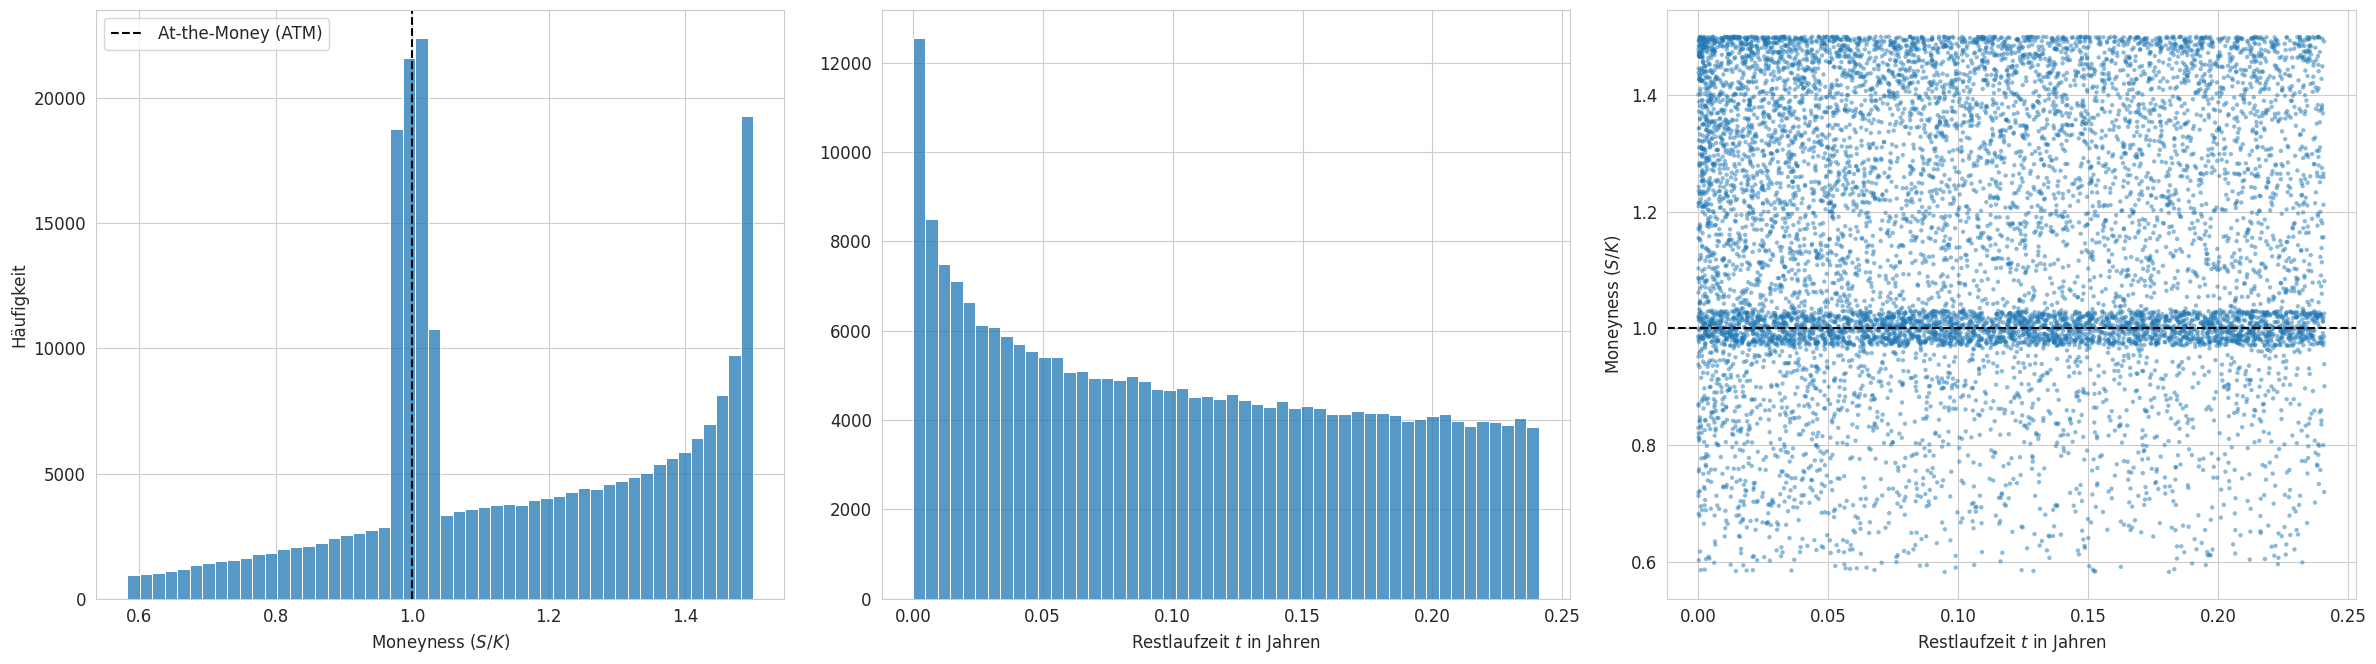

In [15]:
S = Xc_pool[:, 0]
K = Xc_pool[:, 1]
t = Xc_pool[:, 2]

moneyness = S / K

time_to_expiry_years = (90 / 365.25) - t

n_total_points = Xc_pool.shape[0]
n_plot_points = 10_000
plot_indices = np.random.choice(n_total_points, n_plot_points, replace=False)

plot_time = time_to_expiry_years[plot_indices]
plot_moneyness = moneyness[plot_indices]

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(24, 7))
axes = axes.flatten()

sns.histplot(moneyness, kde=False, ax=axes[0], bins=50)
axes[0].set_title('')
axes[0].set_xlabel('Moneyness $(S/K)$')
axes[0].set_ylabel('Häufigkeit')
axes[0].axvline(1.0, color='black', linestyle='--', label='At-the-Money (ATM)')
axes[0].legend()

sns.histplot(time_to_expiry_years, kde=False, ax=axes[1], bins=50)
axes[1].set_title('')
axes[1].set_xlabel('Restlaufzeit $t$ in Jahren')
axes[1].set_ylabel('')

sns.scatterplot(
    x=plot_time,
    y=plot_moneyness,
    s=10,
    alpha=0.5,
    edgecolor='none',
    ax=axes[2]
)
axes[2].axhline(1.0, color='black', linestyle='--', label='At-the-Money (ATM)')

axes[2].set_title('')
axes[2].set_xlabel('Restlaufzeit $t$ in Jahren')
axes[2].set_ylabel('Moneyness $(S/K)$')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("put_colloc_sampling.pdf", bbox_inches="tight")
plt.show()

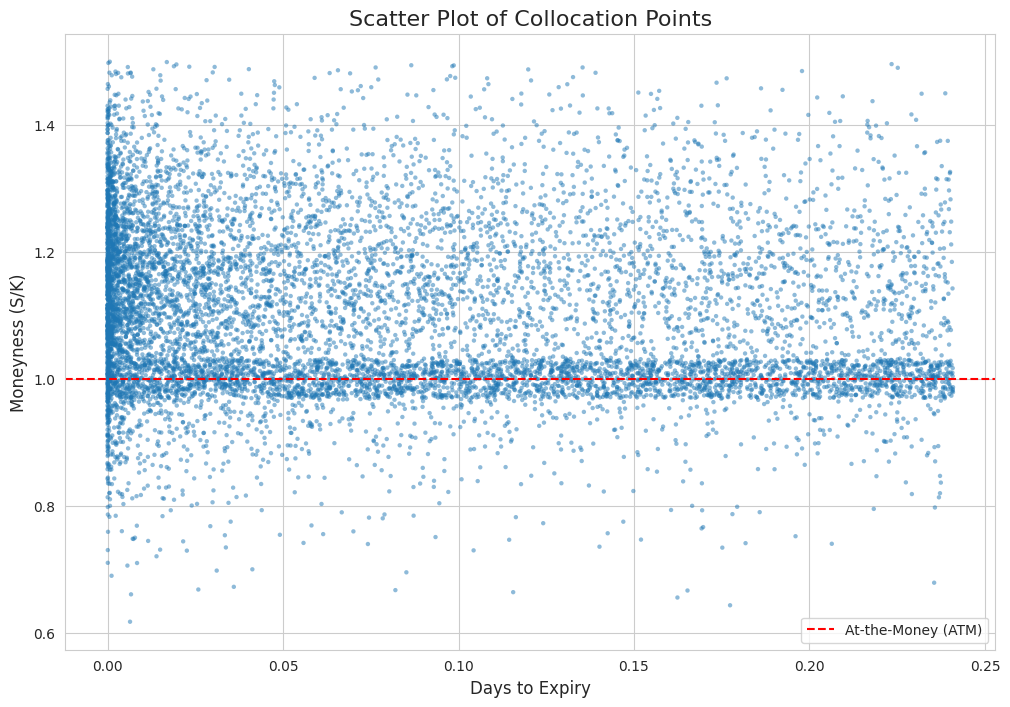

In [18]:
S = Xc_pool[:, 0]
K = Xc_pool[:, 1]
t = Xc_pool[:, 2]

moneyness = S / K

time_to_expiry_years = (90 / 365.25) - t
time_to_expiry_days = time_to_expiry_years

n_total_points = Xc_pool.shape[0]
n_plot_points = 10_000
plot_indices = np.random.choice(n_total_points, n_plot_points, replace=False)

plot_time = time_to_expiry_days[plot_indices]
plot_moneyness = moneyness[plot_indices]

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x=plot_time,
    y=plot_moneyness,
    s=10,
    alpha=0.5,
    edgecolor='none'
)

plt.axhline(1.0, color='r', linestyle='--', label='At-the-Money (ATM)')

plt.title('Scatter Plot of Collocation Points', fontsize=16)
plt.xlabel('Days to Expiry', fontsize=12)
plt.ylabel('Moneyness (S/K)', fontsize=12)
plt.legend()
plt.show()

In [24]:
S_ic = X_ic[:, 0]
K_ic = X_ic[:, 1]
moneyness_ic = S_ic / K_ic
payoff_ic = Y_ic.flatten()

n_total_points = X_ic.shape[0]
n_plot_points = 10_000
plot_indices = np.random.choice(n_total_points, n_plot_points, replace=False)

plot_moneyness_ic = moneyness_ic[plot_indices]
plot_payoff_ic = payoff_ic[plot_indices]

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x=plot_moneyness_ic,
    y=plot_payoff_ic,
    s=15,
    alpha=0.6,
    edgecolor='none'
)

plt.axvline(1.0, color='r', linestyle='--', label='At-the-Money (ATM)')

plt.title('Scatter Plot of IC Points', fontsize=16)
plt.xlabel('Moneyness (S/K)', fontsize=12)
plt.ylabel('Option Payoff (Value at t=T)', fontsize=12)
plt.legend()
plt.show()

NameError: name 'X_ic' is not defined